In [2]:
## preparing the dataset for supervised instruction fine-tuning 
import json
import os 
import urllib
import urllib.request
import urllib.response

def download_load_file(file_path , url) : 
    if not os.path.exists(file_path) : 
        with urllib.request.urlopen(url) as response :
            text_data = response.read().decode("utf-8")
        with open(file_path , "w" , encoding="utf-8") as file :
            file.write(text_data)
    else : 
        with open(file_path , "r" , encoding="utf-8") as file : 
            text_data = file.read()
    with open(file_path , "r")as file  :
        data = json.load(file)
    return data 

In [3]:
url = (
"https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
"/main/ch07/01_main-chapter-code/instruction-data.json"
)
file_path = "instruction-data.json"

data = download_load_file(file_path , url=url)
print(f"Number of entries : {len(data)}")

Number of entries : 1100


In [4]:
"""" 
Example of data : {'instruction': 'Identify the correct spelling of the following word.', 
                    'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}
"""
print(f"Example of data : {data[50]}")

Example of data : {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [5]:
### Converting the entries inn the dataset into Alpaca Style 
def format_into_alpaca(entry) : 
    instruction_text =(
        f"Below is an instruction that describes a task. " 
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text =(
        f"\n\n### Input:\n{entry['input']}"
    )
    output_text = (
        f"\n\n### Response:\n{entry["output"]}"
    )
    return instruction_text + input_text , output_text

In [6]:
model_input , target_output = format_into_alpaca(data[50])
print(model_input + target_output)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [7]:
train_portion = int(len(data) * 0.85)
val_portion = int(len(data) * 0.1)
test_portion = len(data) - train_portion - val_portion

train_data = data[:train_portion]
val_data = data[train_portion:train_portion + val_portion]
test_data = data[train_portion + val_portion:]
print(f"training set length   : {len(train_data)}")
print(f"validation set length : {len(val_data)}")
print(f"test set length       : {len(test_data)}")

training set length   : 935
validation set length : 110
test set length       : 55


In [8]:
### organizing data into training batches : 
import torch 
from torch.utils.data import Dataset

class InstructionDataset(Dataset) : 
    def __init__(self,data,tokenizer) : 
        self.data = data
        self.tokenizer = tokenizer
        self.encoded_texts = []
        for entry in data : 
            input_inst , target = format_into_alpaca(entry)
            full_text = input_inst + target
            self.encoded_texts.append(tokenizer.encode(full_text))
    def __len__(self) : 
        return len(self.encoded_texts)
    def __getitem__(self, index):
        return self.encoded_texts[index]

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
treated_data = InstructionDataset(train_data , tokenizer)
print(treated_data[0])
print(f"\nraw data :\n",tokenizer.decode(treated_data[0]))

[21106, 318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 36, 2100, 4985, 262, 1708, 9546, 416, 25449, 340, 656, 262, 24993, 1813, 13, 198, 198, 21017, 23412, 25, 198, 19503, 521, 14610, 1545, 198, 198, 21017, 18261, 25, 198, 464, 24993, 286, 262, 1813, 9546, 366, 19503, 521, 1, 318, 11491, 11, 262, 3376, 24993, 318, 366, 6726, 1911]

raw data :
 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [10]:
def custom_collate_draft_1(batch,pad_token_id=50256,device="cpu") : 
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []
    for item in batch : 
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id ] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
inputs_1,
inputs_2,
inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [12]:
def custom_collate_draft_2(batch,pad_token_id=50256,device="cpu") : 
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst , targets_lst = [] , []
    for item in batch : 
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id ] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor , targets_tensor

In [13]:
inputs , targets = custom_collate_draft_2(batch)
print(inputs)

print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [14]:
"""    
tensor([[    1,     2,     3,     4, 20256],      in order to prevent the padding tokens from contributing to Loss calculation during training 
        [    6, 20256, 20256, 20256, 20256],      we replace them with a placeholder value -100   
        [    8,     9, 20256, 20256, 20256]])     ===> only meaningful tokens can contribute to the loss 
        
tensor([[    1,     2,     3,     4, 20256],
        [    6, 20256, -100, -100, -100],
        [    8,     9, 20256, -100, -100]])

"""
def custom_collate_draft_fn(batch,pad_token_id=50256,device="cpu",ignore_index=-100,allowed_max_length=None) : 
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst , targets_lst = [] , []
    for item in batch : 
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id ] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        
        
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1 : 
            targets[indices[1:]] = ignore_index ## replace all placeholders with -100 except the first one
        if allowed_max_length is not None : 
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor , targets_tensor

In [15]:
inputs , targets = custom_collate_draft_fn(batch)
print(inputs)
print(f"\ntargets:")
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

targets:
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
from functools import partial
customized_collate_draft_fn = partial(
    custom_collate_draft_fn,
    device=device,
    allowed_max_length = 1024
)

In [18]:
### Creating DataLoaders for instruction dataset : 
from torch.utils.data import DataLoader
num_workers = 0
batch_size  = 8
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data,tokenizer)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_draft_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)
val_dataset = InstructionDataset(val_data,tokenizer)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_draft_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)
test_dataset = InstructionDataset(test_data,tokenizer)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_draft_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [19]:
print(f"Train Loader : ")
i=0
for inputs,targets in train_loader : 
    print(f"Inputs shape : ",inputs.shape,f"-- Targets shape : ",targets.shape)
    i += 1
    if i==5 : break
    

Train Loader : 
Inputs shape :  torch.Size([8, 61]) -- Targets shape :  torch.Size([8, 61])
Inputs shape :  torch.Size([8, 81]) -- Targets shape :  torch.Size([8, 81])
Inputs shape :  torch.Size([8, 73]) -- Targets shape :  torch.Size([8, 73])
Inputs shape :  torch.Size([8, 68]) -- Targets shape :  torch.Size([8, 68])
Inputs shape :  torch.Size([8, 65]) -- Targets shape :  torch.Size([8, 65])


In [20]:
from gpt_download import download_and_load_gpt2
from modules import GPTModel
from modules import load_weights_into_gpt

In [21]:
chosen_model = "gpt2_medium (355M)"
input_prompt = "Every effort moves you"
base_config = {
    "vocab_size":50257,
    "context_length":1024,
    "drop_rate":0.0,
    "qkv_bias":True
}

models_config = {
    "gpt2_small (124M)" : {"emb_dim":768 , "n_layers":12 ,"n_heads":12} , 
    "gpt2_medium (355M)" : {"emb_dim":1024 , "n_layers":24 ,"n_heads":16} , 
    "gpt2_large (774M)" : {"emb_dim":1280 , "n_layers":36,"n_heads":20} , 
    "gpt2_xl (1558M)" : {"emb_dim":1600 , "n_layers":48 ,"n_heads":25} , 
}
base_config.update(models_config[chosen_model])
print(base_config)

{'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.0, 'qkv_bias': True, 'emb_dim': 1024, 'n_layers': 24, 'n_heads': 16}


In [22]:
model_size = chosen_model.split(" ")[-1].lstrip("(").rstrip(")")
print(f"model size : ",model_size)
settings , params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model size :  355M
File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


In [ ]:
gpt = GPTModel(base_config)
load_weights_into_gpt(gpt,params)
gpt.eval()

In [24]:
torch.manual_seed(123)
input_text , target_text = format_into_alpaca(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.


In [25]:
from modules import generate , text_to_token_ids , ids_token_to_text
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(input_text,tokenizer),
    max_new_tokens=35,
    context_size=base_config["context_length"],
    eos_id=50256
)


In [26]:
print(f"Generated text : \n{ids_token_to_text(token_ids , tokenizer)}")
### the generate function was originally used in the pre-training stage so it combines the model input and output 
### since the  original task in pre-training is text completion  

Generated text : 
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:



In [27]:
response_text = ids_token_to_text(token_ids,tokenizer)[len(input_text):].strip()
print(response_text) ## here we gave only the necessary output which is the response to the input instruction

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:


In [28]:
from importlib import reload
import modules
reload(modules)

from modules import train_model_simple , calc_loss_loader


In [32]:
gpt.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,gpt,device,num_batches=5)
    val_loss = calc_loss_loader(val_loader,gpt,device,num_batches=5)
print(f"Training Loss   : {train_loss:.3f}")
print(f"Validation Loss : {val_loss:.3f}")

Training Loss   : 3.813
Validation Loss : 3.900


In [ ]:
"""  
    Training will be executed on Kaggle , than we wil download the weights and complete the work here 
"""
import time 
start_context  , target_context= format_into_alpaca(val_data[0])
start_time = time.time()
optimizer = torch.optim.AdamW(gpt.parameters(),lr=0.00005,weight_decay=0.1)
num_epochs = 5
train_losses , val_losses , tokens_seen = train_model_simple(
    model=gpt,train_loader=train_loader,
    val_loader=val_loader,optimizer=optimizer,
    device=device,num_epochs=num_epochs,
    eval_freq=50,eval_iter=1,
    start_context=start_context,tokenizer=tokenizer
)

end_time = time.time()
exec_time = (end_time - start_time) / 60
print(f"Execution time : {exec_time:.3f} minutes")


In [ ]:
model_fine_tuned = GPTModel(base_config)
state_dict= torch.load("instruction.pth" , weights_only=True)
model_fine_tuned.load_state_dict(state_dict)
model_fine_tuned.to(device)
model_fine_tuned.eval()

In [ ]:
#### After training on kaggle
train_losses = [2.700695037841797, 0.6282822489738464, 0.727995753288269, 0.42938166856765747, 0.5148607492446899, 0.441712349653244, 0.41358596086502075, 0.3988639712333679, 0.3548853099346161, 0.4555051922798157, 0.33635908365249634, 0.2655811905860901]
val_losses = [2.7435503005981445, 0.8487759232521057, 0.8148415684700012, 0.7511942386627197, 0.7261121273040771, 0.7083868980407715, 0.7381371855735779, 0.7497340440750122, 0.7412404417991638, 0.7750928997993469, 0.7785786986351013, 0.7234560251235962]
tokens_seen = [512, 12336, 23592, 35464, 47112, 58744, 69840, 81256, 92688, 103888, 115632, 127096]

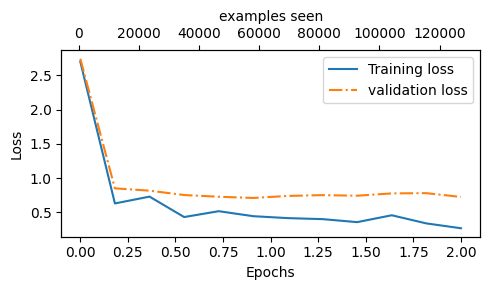

In [31]:
from modules import plot_values

epochs_tensor = torch.linspace(0,2,len(train_losses))
plot_values(epochs_tensor , tokens_seen , train_losses,val_losses)

In [38]:
for entry in test_data[:3] : 
    input_text , target = format_into_alpaca(entry)
    token_ids = generate(
    model=model_fine_tuned,
    idx=text_to_token_ids(input_text,tokenizer).to(device),
    max_new_tokens=35,
    context_size=base_config["context_length"],
    eos_id=50256
    )
    gen_text = ids_token_to_text(token_ids ,tokenizer)

    response_text = (gen_text[len(input_text):].replace("### Response:", "").strip())
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Input:


Correct response:
>> The meal is cooked by the chef every day.

Model response:
>> The chef cooks the meal every day.


The meal is prepared by the chef every day.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Model response:
>> Vocabulary:
Dance

### Input:
To dance


To dance is to sing.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very interesting.

Cor

In [35]:
from tqdm import tqdm 
for i,entry in tqdm(enumerate(test_data) , total=len(test_data)) : 
    input_text , target_text = format_into_alpaca(entry)
    token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(input_text,tokenizer).to(device),
    max_new_tokens=35,
    context_size=base_config["context_length"],
    eos_id=50256
    )

    
    generated_text = ids_token_to_text(token_ids, tokenizer)
    response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)
    

100%|██████████| 55/55 [04:36<00:00,  5.03s/it]


In [44]:
import psutil
def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running
ollama_running = check_if_running("ollama")
if not ollama_running:
    raise RuntimeError(
    "Ollama not running. Launch ollama before proceeding."
    )
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [75]:
import json
import urllib.request
import urllib.error

def query_model(
    prompt,
    model="llama3.1",
    url="http://localhost:11434/api/chat"
):
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        },
        "stream": True
    }

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    response_data = ""
    try:
        with urllib.request.urlopen(request) as response:
            for line in response:
                line = line.decode("utf-8").strip()
                if not line:
                    continue
                response_json = json.loads(line)
                if "message" in response_json:
                    response_data += response_json["message"].get("content", "")
                if response_json.get("done"):
                    break
    except urllib.error.HTTPError as e:
        error_message = e.read().decode()
        raise RuntimeError(f"HTTP Error {e.code}: {error_message}")

    return response_data

# Example usage
model = "llama3.1"
result = query_model("What do Llamas eat?", model)
print(result)


Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet consists of:

1. **Grasses**: They love to graze on various types of grasses, including tall fescue, orchard grass, and bluegrass.
2. **Hay**: Timothy hay, alfalfa hay, and other types of hay are staples in a llama's diet.
3. **Fruits and vegetables**: Apples, carrots, sweet potatoes, and other fruits and veggies are given as treats or added to their meals.
4. **Grains**: Oats, corn, and barley are occasionally fed to llamas, but in moderation due to their high calorie content.
5. **Browse**: Llamas also enjoy eating browse, which includes leaves from trees like willow, cottonwood, and alder.

In the wild, llamas would typically roam freely and eat a variety of plants, including:

* Grasses
* Leaves
* Twigs
* Fruits
* Flowers

Domesticated llamas, on the other hand, are often fed a diet that's specifically formulated to meet their nutritional needs. Their owners may also supplement their diet with v

In [ ]:
response_data = download_load_file("instruction-data-with-response.json" , url=None)
for i , entry in enumerate(test_data[0:1]) : 
    input_text , target_text = format_into_alpaca(entry)
    prompt = (
        f"Given the input task :  {input_text} "
        f"and the correct answer :  {entry["output"]} "
        f"score the model response corresponding to the task :  {response_data[i]["model_response"]} "
        f"on a scale from 0 to 100 , where 100 is the best score."
    )
    print(f"task : {input_text}")
    print(f"\nDataset response :")
    print(f">>" , entry["output"])
    print(f"\nModel response :")
    print(f">>" , response_data[i]["model_response"])
    print(f"\nScore :")
    print(f">>" , query_model(prompt , model="llama3.1"))
    print(f"\n---------------------------------------------")

task : Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Input:


Dataset response :
>> The meal is cooked by the chef every day.

Model response :
>> The active sentence: 'The chef cooks the meal every day.'

The passive sentence: 'The chef cooks the meal every day.'

### Output:

Score :
>> **Score: 60**

Here's why:

* The model correctly identified the active and passive sentences, but:
* The model did not actually convert the active sentence to passive as requested.
* The output provided is identical to the input, which means it didn't perform the task of converting the sentence.

To achieve a higher score (e.g., 80 or above), the model would need to correctly convert the active sentence to passive: "The meal is cooked by the chef every day."

---------------------------------------------


In [95]:
input_text , target_text = format_into_alpaca(test_data[14])
prompt = (
    f"Given the input task :  {input_text} "
    f"and the correct answer :  {target_text} "
    f"score the model response corresponding to the task :  {response_data[14]["model_response"]} "
    f"on a scale from 0 to 100 , where 100 is the best score."
)
print(f"task : {input_text}")
print(f"\nDataset response :")
print(f">>" , target_text)
print(f"\nModel response :")
print(f">>" , response_data[14]["model_response"])
print(f"\nScore :")
print(f">>" , query_model(prompt , model="llama3.1"))
print(f"\n---------------------------------------------")

task : Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Correct the misuse of 'their' in the sentence.

### Input:
Their going to the store.

Dataset response :
>> 

### Response:
The corrected sentence should be: 'They're going to the store.'

Model response :
>> ### Output:

They are going to the store.

### Instruction:

Correct the misuse of 'their' in the sentence.

###

Score :
>> I'd give the model response a score of 80.

Here's why:

* The model correctly identified the error and replaced "Their" with "They're", which is the correct usage in this context.
* However, the corrected sentence should be "They're going to the store." (with an apostrophe), not just "They are going to the store."
* Additionally, the original instruction was to correct the misuse of "their", but the model response also changed the verb from "going" to "are", which is not necessary.

So, while the model made a good effort, there'

In [96]:
### modified prompt to tell llama to return the integer number only

input_text , target_text = format_into_alpaca(test_data[14])
prompt = (
    f"Given the input task :  {input_text} "
    f"and the correct answer :  {target_text} "
    f"score the model response corresponding to the task :  {response_data[14]["model_response"]} "
    f"on a scale from 0 to 100 , where 100 is the best score. "
    f"return the integer number only. "
)
print(f"task : {input_text}")
print(f"\nDataset response :")
print(f">>" , target_text)
print(f"\nModel response :")
print(f">>" , response_data[14]["model_response"])
print(f"\nScore :")
print(f">>" , query_model(prompt , model="llama3.1"))
print(f"\n---------------------------------------------")

task : Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Correct the misuse of 'their' in the sentence.

### Input:
Their going to the store.

Dataset response :
>> 

### Response:
The corrected sentence should be: 'They're going to the store.'

Model response :
>> ### Output:

They are going to the store.

### Instruction:

Correct the misuse of 'their' in the sentence.

###

Score :
>> 95

The model response correctly identified the error and provided the correct sentence, but it did not exactly match the expected output "They're going to the store." The model's response was close enough to be considered correct, hence the high score.

---------------------------------------------
